# Рекомендация тарифов

# Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Модели
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.dummy import DummyClassifier



# Изучение данных

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


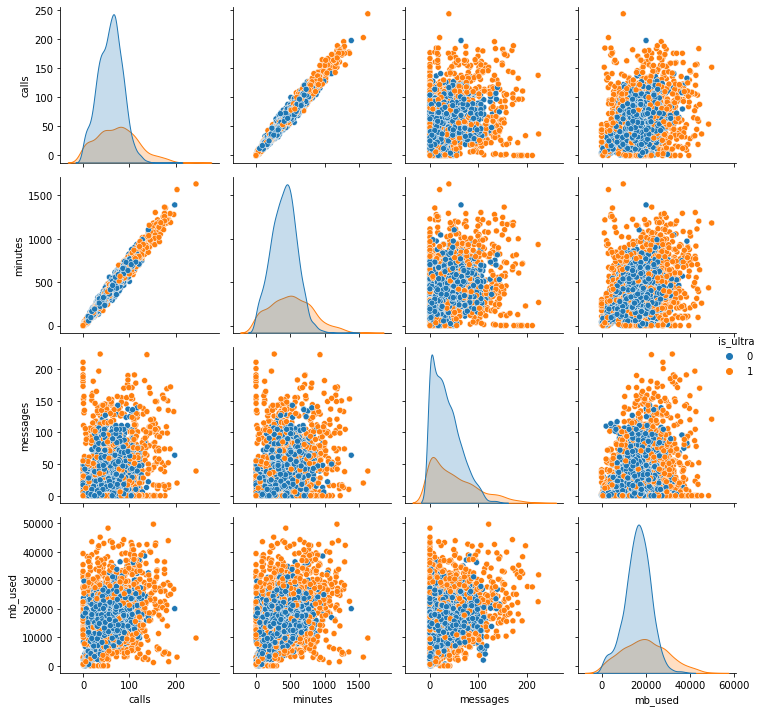

In [6]:
sns.pairplot(data, hue='is_ultra')
plt.tight_layout() # убираем служебную информацию

**Выводы**

Поскольку предобработка данных уже проведена стоит сфокусироваться на основных задачах проекта: 
- Разделить исходные данные на обучающую, валидационную и тестовую выборки.
- Протестировать качество моделей DecisionTreeClassifier, RandomForestClassifier, LogisticRegression. Сделать краткие выводы по каждой.
- Добиться минимальной accuracy 0.75
- Проверить качество модели на тестовой выборке.
- Проверить модели на вменяемость

# Тестируем модели

## Разобьем данные на выборки

In [7]:
data_train, data_valid_test = train_test_split(data, test_size=0.40,
                                      random_state=42)

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 2369 to 3174
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     1928 non-null   float64
 1   minutes   1928 non-null   float64
 2   messages  1928 non-null   float64
 3   mb_used   1928 non-null   float64
 4   is_ultra  1928 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 90.4 KB


In [9]:
data_valid_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286 entries, 506 to 2009
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     1286 non-null   float64
 1   minutes   1286 non-null   float64
 2   messages  1286 non-null   float64
 3   mb_used   1286 non-null   float64
 4   is_ultra  1286 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 60.3 KB


In [10]:
#отделим тестовую выборку от валидационной
data_valid, data_test = train_test_split(data_valid_test, test_size=0.5,
                                      random_state=42) 

In [11]:
data_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 1198 to 1510
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     643 non-null    float64
 1   minutes   643 non-null    float64
 2   messages  643 non-null    float64
 3   mb_used   643 non-null    float64
 4   is_ultra  643 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 30.1 KB


In [12]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 1545 to 283
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     643 non-null    float64
 1   minutes   643 non-null    float64
 2   messages  643 non-null    float64
 3   mb_used   643 non-null    float64
 4   is_ultra  643 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 30.1 KB


## Протестируем модель DecisionTreeClassifier

### Создадим все необходимые срезы

In [13]:
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']
features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']



In [14]:
best_model = None
best_result = 0

for depth in range(1, 5):
    for sample_split in range(3, 15):
        for sample_leaf in range(3, 20):
        
            model = DecisionTreeClassifier(max_depth=depth,
                                           min_samples_split=sample_split,
                                           random_state=42,
                                           min_samples_leaf=sample_leaf)
            model.fit(features_train, target_train)
            result = model.score(features_valid, target_valid)
            predictions_valid = model.predict(features_valid)
            if result > best_result:
                best_model = model 
                best_result = result
                best_depth = depth
                best_sample_split = sample_split
                best_sample_leaf = sample_leaf
        
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("При глубине:", best_depth)
print("При min_samples_split:", best_sample_split)
print("При min_samples_leaf:", best_sample_leaf)





Accuracy наилучшей модели на валидационной выборке: 0.7962674961119751
При глубине: 4
При min_samples_split: 3
При min_samples_leaf: 9


**Выводы**

При указанных гиперпараметрах на валидационной выборке accuracy = 0.7962674961119751

# Поиск гиперпараметров с использованием GridSearch

Для ускорения работы алгоритмов предлагаю в дальнейшем использовать GridSearch

## Протестируем модель RandomForestClassifier

In [15]:
model = RandomForestClassifier(random_state=42)

In [16]:
params = {'max_depth': range(1, 15) , 
          'n_estimators':[5,20, 25],
          'min_samples_split':[2, 6, 10],
          'min_samples_leaf':[1, 3, 4],
           'bootstrap': [True, False],
            }

grid_model_forest = GridSearchCV(model, params, cv=3,
                          scoring='accuracy', n_jobs=-1)

grid_model_forest.fit(features_train, target_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': range(1, 15),
                         'min_samples_leaf': [1, 3, 4],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [5, 20, 25]},
             scoring='accuracy')

In [17]:
grid_model_forest.best_score_ # выведем accuracy


0.810681853784425

In [18]:
grid_model_forest.best_params_ # выведем параметры

{'bootstrap': True,
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}

In [19]:
preds = grid_model_forest.predict(features_valid)

In [20]:
accuracy_score(target_valid, preds)

0.807153965785381

**Вывод**

При указанных гиперпараметрах на валидационной выборке accuracy = 0.807153965785381

## Протестируем модель LogisticRegression

In [21]:
modelregr = LogisticRegression(random_state=42)

In [23]:
params = {
          'C': np.logspace(-4, 4, 50),
           'max_iter': [200, 500]
    
          
            }

grid_model_regr = GridSearchCV(modelregr, params, cv=3,
                          scoring='accuracy', n_jobs=-1)

grid_model_regr.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-0...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'max_iter': [200, 500]},
             scoring='accuracy')

In [24]:
grid_model_forest.best_score_ 

0.810681853784425

In [25]:
grid_model_regr.best_params_ 

{'C': 9.999999999999999e-05, 'max_iter': 200}

In [26]:
preds = grid_model_regr.predict(features_valid)

In [27]:
accuracy_score(target_valid, preds)

0.7402799377916018

**Вывод**

При указанных гиперпараметрах на валидационной выборке accuracy = 0.7402799377916018

**Общий Вывод**
При автоматической подборке параметров наибольший показатель accuracy выявлен у модели RandomForestClassifier наименьший у LogisticRegression

## Протестируем модель RandomForestClassifier на тестовой выборке

In [28]:
preds = grid_model_forest.predict(features_test)

In [29]:
accuracy_score(target_test, preds)

0.8242612752721618

# Проверка моделей на вменяемость при помощи DummyClassifier

In [30]:
dummymodel = DummyClassifier(random_state=42).fit(features_train, target_train)

In [31]:
preds_valid = dummymodel.predict(features_valid)

In [32]:
accuracy_score(target_valid, preds_valid)

0.6936236391912908

In [33]:
preds_test = dummymodel.predict(features_test)

In [35]:
accuracy_score(target_test, preds_test)

0.6967340590979783

**Вывод**

При проверке на вменяемость удалось установить, что модели показывают точность выше чем DummyClassifier и, как следствие вменяемы